# Introduction


Our group has chosen to investigate a dataset on US auto insurance claims, focusing on the outcome variable of fraud incidence. The original dataset is of size 1000 x 39, and was originally found on Kaggle [[1]](https://www.kaggle.com/buntyshah/auto-insurance-claims-data). </br></br>
There are several reasons for why understanding and predicting fraud incidence in auto insurance might be an interesting. From the perspective of an auto insurance provider, the incentive is clear. In 2012, fraud accounted for 15% - 17% of the total claims for bodily injury in the US [[2]](https://www.iii.org/article/background-on-insurance-fraud). Mitigating insurance fraud can lead to large increases in profitability. Moreover, the benefit for the consumer is notable as well. A significant portion of these fraud losses are passed on to consumers in the form of higher prices [[3]](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/494105/PU1817_Insurance_Fraud_Taskforce.pdf). </br></br> 
Understanding associations between fraud and different predictors might provide motivation for important causation-focused studies that may lead to interventions that reduce fraud incidence. For example, A/B testing the effect of different deductibles (required payment by the claimant before the insurance provider is liable for remaining expense) or umbrella limits (maximum payment made by insurance provider on an umbrella policy – umbrella policies are policies that cover any expenses that exceed individual policy limits).</br></br>
Accurate prediction of fraud incidence is arguably even more important than understanding it. Identifying fraud incidence has the twofold effect of reducing expenses paid and discouraging future attempts to defraud insurance providers. </br></br>






# Exploratory data analysis and preprocessing

The purpose of this section is to understand the properties of this dataset so that we can make informed choices as to which methods will be most compatible with our dataset and to preprocess the data such that it is ready to be used to fit our models.

## Importing libraries and data

In [ ]:
#Basic libraries
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt

#Visualisation libraries
import seaborn as sns
sns.set_theme(style="darkgrid")
import plotly.express as px
import plotly.graph_objects as go
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

#Machine Learning Libraries
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from statsmodels.discrete.discrete_model import Logit
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [ ]:
raw_data = pd.read_csv('insurance_claims.csv')
print(raw_data.shape)
raw_data.head(10)

(1000, 40)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
5,256,39,104594,2006-10-12,OH,250/500,1000,1351.10,0,478456,FEMALE,PhD,tech-support,bungie-jumping,unmarried,0,0,2015-01-02,Multi-vehicle Collision,Rear Collision,Major Damage,Fire,SC,Arlington,8973 Washington St,19,3,NO,0,2,NO,64100,6410,6410,51280,Saab,95,2003,Y,NaN
6,137,34,413978,2000-06-04,IN,250/500,1000,1333.35,0,441716,MALE,PhD,prof-specialty,board-games,husband,0,-77000,2015-01-13,Multi-vehicle Collision,Front Collision,Minor Damage,Police,NY,Springfield,5846 Weaver Drive,0,3,?,0,0,?,78650,21450,7150,50050,Nissan,Pathfinder,2012,N,NaN
7,165,37,429027,1990-02-03,IL,100/300,1000,1137.03,0,603195,MALE,Associate,tech-support,base-jumping,unmarried,0,0,2015-02-27,Multi-vehicle Collision,Front Collision,Total Loss,Police,VA,Columbus,3525 3rd Hwy,23,3,?,2,2,YES,51590,9380,9380,32830,Audi,A5,2015,N,NaN
8,27,33,485665,1997-02-05,IL,100/300,500,1442.99,0,601734,FEMALE,PhD,other-service,golf,own-child,0,0,2015-01-30,Single Vehicle Collision,Front Collision,Total Loss,Police,WV,Arlington,4872 Rock Ridge,21,1,NO,1,1,YES,27700,2770,2770,22160,Toyota,Camry,2012,N,NaN
9,212,42,636550,2011-07-25,IL,100/300,500,1315.68,0,600983,MALE,PhD,priv-house-serv,camping,wife,0,-39300,2015-01-05,Single Vehicle Collision,Rear Collision,Total Loss,Other,NC,Hillsdale,3066 Francis Ave,14,1,NO,2,1,?,42300,4700,4700,32900,Saab,92x,1996,N,NaN


In [ ]:
data = raw_data.copy()
data.describe(include='all')

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
count,1000.000000,1000.000000,1000.000000,1000,1000,1000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000,1000,1000,1000,1000,1000.000000,1000.000000,1000,1000,1000,1000,1000,1000,1000,1000,1000.000000,1000.00000,1000,1000.000000,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000,1000,0.0
unique,NaN,NaN,NaN,951,3,3,NaN,NaN,NaN,NaN,2,7,14,20,6,NaN,NaN,60,4,4,4,5,7,7,1000,NaN,NaN,3,NaN,NaN,3,NaN,NaN,NaN,NaN,14,39,NaN,2,NaN
top,NaN,NaN,NaN,2006-01-01,OH,250/500,NaN,NaN,NaN,NaN,FEMALE,JD,machine-op-inspct,reading,own-child,NaN,NaN,2015-02-02,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Springfield,2381 1st Hwy,NaN,NaN,?,NaN,NaN,?,NaN,NaN,NaN,NaN,Suburu,RAM,NaN,N,NaN
freq,NaN,NaN,NaN,3,352,351,NaN,NaN,NaN,NaN,537,161,93,64,183,NaN,NaN,28,419,292,354,292,262,157,1,NaN,NaN,360,NaN,NaN,343,NaN,NaN,NaN,NaN,80,43,NaN,753,NaN
mean,203.954000,38.948000,546238.648000,NaN,NaN,NaN,1136.000000,1256.406150,1.101000e+06,501214.488000,NaN,NaN,NaN,NaN,NaN,25126.100000,-26793.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.644000,1.83900,NaN,0.992000,1.487000,NaN,52761.94000,7433.420000,7399.570000,37928.950000,NaN,NaN,2005.103000,NaN,NaN
std,115.113174,9.140287,257063.005276,NaN,NaN,NaN,611.864673,244.167395,2.297407e+06,71701.610941,NaN,NaN,NaN,NaN,NaN,27872.187708,28104.096686,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.951373,1.01888,NaN,0.820127,1.111335,NaN,26401.53319,4880.951853,4824.726179,18886.252893,NaN,NaN,6.015861,NaN,NaN
min,0.000000,19.000000,100804.000000,NaN,NaN,NaN,500.000000,433.330000,-1.000000e+06,430104.000000,NaN,NaN,NaN,NaN,NaN,0.000000,-111100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.00000,NaN,0.000000,0.000000,NaN,100.00000,0.000000,0.000000,70.000000,NaN,NaN,1995.000000,NaN,NaN
25%,115.750000,32.000000,335980.250000,NaN,NaN,NaN,500.000000,1089.607500,0.000000e+00,448404.500000,NaN,NaN,NaN,NaN,NaN,0.000000,-51500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,1.00000,NaN,0.000000,1.000000,NaN,41812.50000,4295.000000,4445.000000,30292.500000,NaN,NaN,2000.000000,NaN,NaN
50%,199.500000,38.000000,533135.000000,NaN,NaN,NaN,1000.000000,1257.200000,0.000000e+00,466445.500000,NaN,NaN,NaN,NaN,NaN,0.000000,-23250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,1.00000,NaN,1.000000,1.000000,NaN,58055.00000,6775.000000,6750.000000,42100.000000,NaN,NaN,2005.000000,NaN,NaN
75%,276.250000,44.000000,759099.750000,NaN,NaN,NaN,2000.000000,1415.695000,0.000000e+00,603251.000000,NaN,NaN,NaN,NaN,NaN,51025.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.000000,3.00000,NaN,2.000000,2.000000,NaN,70592.50000,11305.000000,10885.000000,50822.500000,NaN,NaN,2010.000000,NaN,NaN


## Understanding the predictors

We will begin by going through the unintuitive predictors and try to understand what they represent.

* `policy_number` seems to be an unique ID.

 * `policy_bind_date` does not seem to be multicollinear with `months_as_customer`. We assume this is because customers can change policies and that `policy_bind_date` is the bind date of the most recent policy.

* `policy_csl` seems to represent a policy's 'combined single limits'. This is a "provision of an insurance policy that limits the coverage for all components of a claim to a single dollar amount", as opposed to 'split limits' which denotes seperate limits for 'payment per person due to bodily injury', 'total payment for the incident' and 'property damage', although that last limit is not a standard part of all policies [[4]](https://www.investopedia.com/terms/c/combined-single-limits.asp). Oddly enough, all the data for the `policy_csl` column is in the format 'x/y', which is commonly used to denote split limits where 'x' is the per person limit and 'y' is the per incident limit and x > y. Further research shows that the three unique data points for the `policy_csl` column, `100/300`, `250/500` and `500/1000` are common limits offered in the US (units are in 000s). Hence we will go with the interpretation of the `policy_csl` column as the split limits for the claimant. We can interpret `100/300`, `250/500` and `500/1000` as low, medium and high insurance coverage respectively.

* `policy_deductible` and `umbrella_limit` are explained in the Introduction.

* `insured_zip` would in theory contain the zip code of the claimant's address, but oddly we were unable to find any zip code format (or even a subsection of a zip code) that would match the data.

* `capital-gains` and `capital-loss` is a very confusing black box. It does not seem to have a consistent relationship with any linear combination of `policy_deductable`, `policy_annual_premium` `total_claim_amount`, `injury_claim`, `property_claim`	or `vehicle_claim`. Further research has not proven fruitful either. Moreover, the data is provided in multiples of 100, implying that there is some rounding going on at some stage. We will likely drop this predictor due to its uninterpretability.

* `collision_type` seems to have `?` when no collision has occured e.g. for vehicle theft. This is fine. On the other hand, the occurence of `?` in the `property_damage` and `police_report_available` seem to represent missing data. We will have to decide how we wish to deal with this later.

## Dropping irrelevant predictors

* We drop `_c39` because it is an emtpy column.
* We will drop `policy_number` as it an unique ID.
* We drop `insured_zip`, `capital-gains` and `capital-loss` because we are not sure what these predictors represent.
* We drop `incident_location` and `incident_city` because we are not interested in that level of location specifity for this analysis. Moreover, to conduct useful analysis of fraud incidence and location, we would require a much larger dataset, data from a much greater variety of locations and a good way of binning them. It suffices to say that this is out of the scope of this analysis.
* `auto_model` is also a level of granularity that will also likely not be useful in this analysis for similar reasons. `auto_make` will likely contain most of the signal in `auto_model` with much less of the noise.
* We drop `insured_hobbies` because this data is likely not available for most fraud insurance prediction tasks, so it is not useful to include it in this analysis if what we are focused on is OOD generalization.

We are now left with 30 predictors out of our original 39.

In [ ]:
data.drop(labels=['_c39', 'policy_number', 'insured_zip', 'capital-gains', 'capital-loss', 
                  'incident_location', 'incident_city', 'auto_model', 'insured_hobbies'],
           axis=1, inplace=True)

## Cleaning predictors

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_bind_date             1000 non-null   object 
 3   policy_state                 1000 non-null   object 
 4   policy_csl                   1000 non-null   object 
 5   policy_deductable            1000 non-null   int64  
 6   policy_annual_premium        1000 non-null   float64
 7   umbrella_limit               1000 non-null   int64  
 8   insured_sex                  1000 non-null   object 
 9   insured_education_level      1000 non-null   object 
 10  insured_occupation           1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  incident_date                1000 non-null   object 
 13  incident_type      

In [ ]:
#we want to convert policy_bind_date and incident_date to ordinal datetime to make regression easier
#we will covert back from ordinal time when we wish to interpret results (such as in the Logistic Regression section)
data[['policy_bind_date', 'incident_date']] = data[['policy_bind_date', 'incident_date']].apply(pd.to_datetime)
data['policy_bind_date'] = data['policy_bind_date'].apply(lambda x: x.toordinal())
data['incident_date'] = data['incident_date'].apply(lambda x: x.toordinal())

#property_damage and policy_report_available is represented by '?' – convert to None type
data[['property_damage', 'police_report_available']] = data[['property_damage', 
                                                             'police_report_available']].replace({'?': np.nan})
#property_damage, policy_report_available and fraud_reported are of 'object' type when they should be of 'int' type
data[['property_damage', 'police_report_available']] = data[['property_damage', 
                                                             'police_report_available']].replace({'YES': 1, 'NO': 0})
data['fraud_reported'] = data['fraud_reported'].replace({'Y': 1, 'N': 0})

In [ ]:
#Results look good
data[['property_damage', 'police_report_available', 'fraud_reported']].head()

,property_damage,police_report_available,fraud_reported
0,1.0,1.0,1
1,NaN,NaN,1
2,0.0,0.0,0
3,NaN,0.0,1
4,0.0,0.0,0


## Binning predictors

As per [[5]](https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when?rq=1), one should avoid binning variables unless "one has an a priori theory of the scale of aggregation (how many units to aggregate to) and the categorization function of aggregation (which individual observations will end up in which aggregate units)". As this does not apply to any of our predictors, we avoid binning any of our predictors.<br><br>
As an aside, the reason we include this section is because we had originally planned to bin the `policy_bind_date` and `policy_annual_premium` predictors. We changed our minds after conducting further research.

## Checking for multicollinear predictors

In [ ]:
#We use a correlation matrix to conduct a crude multicollinearity check
data_columns = data.columns.tolist()
corr_matrix = data[data_columns].corr()
fig = go.Figure(data = go.Heatmap(
                                z = corr_matrix.values,
                                x = list(corr_matrix.columns),
                                y = list(corr_matrix.index)))
fig.update_layout(title = 'Correlation')
fig.show()

There is perfect multicollinearity between `total_claim_amount` and `vehicle_claim`, `property_claim` and `injury_claim`, which makes sense because `total_claim_amount` is just the sum of the other three. Unfortunately, there is also strong correlations between the three component claim amounts. This is an issue because we believe that there is some value in keeping vehicle, property, and injury claims separate. For example, it is possible that fraud cases might have large values `property_claim` but low values for `injury_claim` because it is easier (and more pleasant) to fake property destruction than it is hospitalization costs from bodily injury. Therefore we will only drop `total_claim_amount` and will just have to deal with the less precise estimates for these other predictors.

We arrive at a similar tension for the high correlation between `age` and `months_as_customer`. We are interested in both these variables for different reasons – `months_as_customer` becasue presumably if someone is committing multiple counts of insurance fraud, they are doing so with multiple different insurance providers, and hence will not have been customers for very long. Moreover, would not want to pay annual premiums for a long time if they are only a customer to conduct fraud. `age` is interesting becasue it might be that younger age groups are more likely to commit fraud (or crimes in general). However, in this instance, the level of multicollinearity is much higher than in the above case (z > 0.9 here while above 0.5 < z < 0.7). Additionally, `months_as_customer` might capture a lot of the signal that we wish to capture with `age`. Therefore we will drop `age`.

In [ ]:
#Drop total_claim_amount and age
data.drop(labels=['total_claim_amount', 'age'], axis = 1, inplace = True)

We are now left with 28 predictors out of the original 39.

## Train/test split

In [ ]:
y = data['fraud_reported']
X = data.drop('fraud_reported', axis=1)
#train/test split of 'default' ratio 80/20, which seems reasonable given n=1000 and p=29
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345) 
#random_state seed for replicability

## Dealing with missing data

As mentioned above, `property_damage` and `police_report_available` have missing data. These also are the only predictors that have missing data. As we believe there are _a priori_ reasons for why these predictors might be useful in predicting fraud incidence, we also cannot just drop these predictors.

In [ ]:
#Checking how many missing values in the property_damage and police_report_available columns
data[['property_damage', 'police_report_available']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   property_damage          640 non-null    float64
 1   police_report_available  657 non-null    float64
dtypes: float64(2)
memory usage: 15.8 KB


With >300 observations having missing values, we also cannot drop the observations with missing values. We address this issue of missing data by single imputation. We believe that multiple imputation is unneccesary because it seems plausible that the data is not missing in a systematic way (MCAR/MAR assumption satisfied) [[6]](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-017-0442-1). We acknowledge that this may lead to an underestimation of the variability of certain predictors, and that this should be considered when viewing the results of this report's analysis. As is good statistical practice, we impute the training and testing data seperately to prevent any information leakage from the test data.

In [ ]:
#Impute's missing value through 'univariate feature imputation'. 'Multivariate feature imputation' is not
#available due to the presence of categorial variables in the data.
#See [7]https://scikit-learn.org/stable/modules/impute.html#impute for more.


s_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent') 
#random_state is to provide a seed for replicability
#Training data multivariate feature imputation
s_imputer.fit(X_train[['property_damage', 'police_report_available']]);
X_train[['property_damage', 'police_report_available']] = s_imputer.transform(X_train[['property_damage', 
                                                                                       'police_report_available']]);
# #Test data multivariate feature imputation
s_imputer.fit(X_test[['property_damage', 'police_report_available']]);
X_test[['property_damage', 'police_report_available']] = s_imputer.transform(X_test[['property_damage', 
                                                                                     'police_report_available']]);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [ ]:
#Looks good
X_train[['property_damage','police_report_available']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 839 to 482
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   property_damage          800 non-null    float64
 1   police_report_available  800 non-null    float64
dtypes: float64(2)
memory usage: 18.8 KB


## Scaling the data

Feature scaling is important since we will later be using models that is sensitive to the scale of the data (e.g. penalized logistic regression). Moreover, it will help speed up the convergence of our gradient descent algorithm [[8]](https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35). We will standardise using the Standard Scaler, $ z = {x-\mu\over \hat\sigma}$. As in the earlier section, we will avoid using the test data when calculating $\mu$ and $\hat\sigma$ to prevent information leakage.

In [ ]:
scaler = StandardScaler()
#Temporarily drop categorical variables so that we can scale the rest of the variables
X_train_copy = X_train.select_dtypes(exclude='object')
X_test_copy = X_test.select_dtypes(exclude='object')
#Standardize data
scaler = scaler.fit(X_train_copy)
scaled_X_train = scaler.transform(X_train_copy)
scaled_X_test = scaler.transform(X_test_copy) #Note we use train parameters to scale test data
#Convert scaled data back to a pandas dataframe
scaled_X_train = pd.DataFrame(scaled_X_train, index=X_train_copy.index, columns=X_train_copy.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, index = X_test_copy.index, columns=X_test_copy.columns)
#Recombine data i.e. paste categorical variables to the right of the now standardized numeric variables
X_train = pd.concat([scaled_X_train, X_train.select_dtypes(include='object')], axis=1)
X_test =  pd.concat([scaled_X_test, X_test.select_dtypes(include='object')], axis=1)

## Checking for imbalanced classes

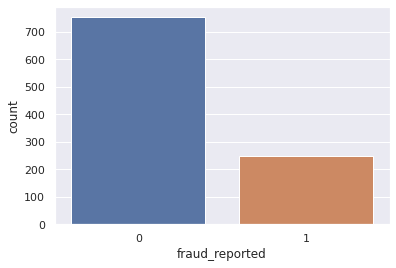

In [ ]:
sns.countplot(x='fraud_reported', data = data)

It seems our classes are quite imbalanced, as is usually the case in fraud detection tasks. This has multiple important implications for our analysis. Firstly, it implies that accuracy is not the best metric to assess model performance. Instead we can use ROC/AUC as a performance metric because it considers both the sensitivity and the specificity of the model. <br><br>
Most classification models seek to maximise accuracy, and hence work best when the classes are relatively balanced. One common technique in the precense of imbalanced classes is to randomly discard data from the majority class until the classes are relatively balanced. However, this is most useful with very large datasets, which we do not have here. In fact, our training dataset of n = 800 and p = 28 is already on the smaller side. Discarding data would lead to our dataset to be problematically small. Instead we will use an over-sampling technique to balance our classes. Specifically, we will use the Synthetic Minority Over-sampling Technique (SMOTE). This works by looking at an observation in the minority class and then generating new samples through interpolation. SMOTE uses KNN to ensure that these new samples are relatively similar to the original data in the feature space [[9]](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn). One of the downsides of SMOTE is that new samples are created without considering the majority class, which can raise issues if there is a large overlap between the majority and minority classes in the feature space [[10]](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/). It is recommended that oversampling the minority class followed by undersampling the majority class outperforms only oversampling [[11]](https://arxiv.org/abs/1106.1813). We only apply SMOTE and undersampling to the training set to avoid information leakage.

In [ ]:
#SMOTENC is a version of smote that works on both numeric and categorical features
over = SMOTENC(random_state=12345, categorical_features=[16, 17, 18, 19, 20, 21, 
                                                         22, 23, 24, 25, 26, 27], sampling_strategy = 0.668)
#random_seed for replicability
#last 12 columns of the dataset are categorical
#sampling_strategy specifies that new minority/majority ratio is 0.668 
#sampling_strategy chosen such that final training set size after balancing classes is n=800 – same as original size 
X_train_smote, y_train_smote = over.fit_resample(X_train, y_train)

under = RandomUnderSampler(random_state=12345)
#random_seed for replicability
#default sampling_strategy means that new minority/majority ratio is 1, i.e. perfectly balanced classes
X_train_smote, y_train_smote = under.fit_resample(X_train_smote, y_train_smote)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [ ]:
#We need to convert data back to DataFrame format
X_train = pd.DataFrame(data=X_train_smote, index=X_train.index, columns=X_train.columns)
X_train = X_train.infer_objects() #infer best data type
X_train.info() #looks good
#No need to convert y_train since it just a 1D array
y_train = y_train_smote

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 839 to 482
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           800 non-null    float64
 1   policy_bind_date             800 non-null    float64
 2   policy_deductable            800 non-null    float64
 3   policy_annual_premium        800 non-null    float64
 4   umbrella_limit               800 non-null    float64
 5   incident_date                800 non-null    float64
 6   incident_hour_of_the_day     800 non-null    float64
 7   number_of_vehicles_involved  800 non-null    float64
 8   property_damage              800 non-null    float64
 9   bodily_injuries              800 non-null    float64
 10  witnesses                    800 non-null    float64
 11  police_report_available      800 non-null    float64
 12  injury_claim                 800 non-null    float64
 13  property_claim    

800


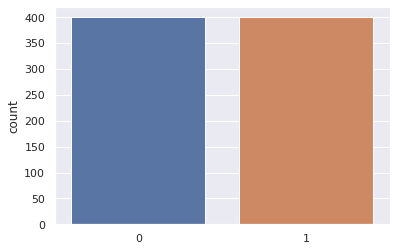

In [ ]:
print(y_train.size)
sns.countplot(x=y_train)
#Equal class representation, 'new' n = 800.

## Encoding categorical variables

Our dataset contains both numeric (p=16) and categorical predictors (p=12). We use one-hot (dummy variable) encoding (as opposed to ordinal encoding) in order to avoid models interpreting the encoded categorical variables as ordered when in reality the ordering is arbitrary (e.g. for `policy_state`).

In [ ]:
cat_columns = list(X_train.select_dtypes(include='object').columns)
#extract categorical column labels – recall from 'Cleaning predictors' all categorical variables have dtype 'object'
X_train = pd.get_dummies(X_train, columns = cat_columns, prefix = cat_columns)
X_test = pd.get_dummies(X_test, columns = cat_columns, prefix = cat_columns)
X_train.shape

(800, 89)

Unfortunately, one hot encoding brings its own disadvantages. While previously we had n=800 and p=28, now we have n=800 and p=89 – relatively high-dimensional data, bringing the issue of the curse of dimensionality to the fore. This issue can be addressed by combining models with methods like the lasso, which performs both feature selection and regularization. <br><br> 
Note we perform our encoding after SMOTE because SMOTE relies on nearest neighbors logic when oversampling. This is also why we scale the data once before encoding and once afterwards.

In [ ]:
#Restandardize X_train_onehot since now some variables are standardized and some are not.
#We still had to previously standardize for the purposes of good SMOTENC
scaler = StandardScaler()
#Standardize data
scaler = scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test) #Note we use train parameters to scale test data
#Convert scaled data back to a pandas dataframe
scaled_X_train = pd.DataFrame(scaled_X_train, index=X_train.index, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_test, index = X_test.index, columns=X_test.columns)
#Recombine data i.e. paste categorical variables to the right of the now standardized numeric variables
X_train = pd.concat([scaled_X_train, X_train.select_dtypes(include='object')], axis=1)
X_test =  pd.concat([scaled_X_test, X_test.select_dtypes(include='object')], axis=1)
X_train

,months_as_customer,policy_bind_date,policy_deductable,policy_annual_premium,umbrella_limit,incident_date,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_year,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,insured_sex_FEMALE,insured_sex_MALE,insured_education_level_Associate,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,...,insured_relationship_unmarried,insured_relationship_wife,incident_type_Multi-vehicle Collision,incident_type_Parked Car,incident_type_Single Vehicle Collision,incident_type_Vehicle Theft,collision_type_?,collision_type_Front Collision,collision_type_Rear Collision,collision_type_Side Collision,incident_severity_Major Damage,incident_severity_Minor Damage,incident_severity_Total Loss,incident_severity_Trivial Damage,authorities_contacted_Ambulance,authorities_contacted_Fire,authorities_contacted_None,authorities_contacted_Other,authorities_contacted_Police,incident_state_NC,incident_state_NY,incident_state_OH,incident_state_PA,incident_state_SC,incident_state_VA,incident_state_WV,auto_make_Accura,auto_make_Audi,auto_make_BMW,auto_make_Chevrolet,auto_make_Dodge,auto_make_Ford,auto_make_Honda,auto_make_Jeep,auto_make_Mercedes,auto_make_Nissan,auto_make_Saab,auto_make_Suburu,auto_make_Toyota,auto_make_Volkswagen
839,-0.764528,-1.383988,1.389903,-0.191667,-0.496203,1.850114,1.521277,0.143747,-0.639646,-0.031958,-1.420850,-0.695979,-0.081324,1.501639,0.717090,-1.371946,-0.774597,1.574249,-0.713746,-0.752036,-0.729772,1.559960,0.965592,-0.965592,-0.377964,-0.384417,2.368875,-0.454573,-0.407653,-0.399275,-0.409736,-0.220211,-0.249834,-0.284747,-0.321634,-0.263664,4.048618,-0.321634,-0.297381,-0.244137,...,-0.362687,-0.426244,1.178159,-0.241249,-0.909112,-0.282174,-0.397168,1.798000,-0.707770,-0.644926,1.136778,-0.637162,-0.525278,-0.249834,1.889822,-0.507801,-0.274352,-0.598527,-0.565802,-0.344791,-0.60238,-0.142857,-0.123404,-0.672239,-0.321634,2.081666,-0.238334,-0.289846,-0.307232,-0.276977,-0.347056,-0.326344,-0.229416,-0.220211,-0.269047,-0.302333,-0.276977,-0.241249,-0.226381,3.280961
195,-1.574057,-1.303932,-0.252394,-0.750129,-0.496203,0.879337,-1.125680,-0.832961,-0.639646,1.197183,-1.420850,-0.695979,-1.621141,-1.601960,-2.190251,1.231534,-0.774597,-0.635223,1.401058,-0.752036,-0.729772,1.559960,-1.035635,1.035635,-0.377964,-0.384417,-0.422141,-0.454573,2.453068,-0.399275,-0.409736,-0.220211,-0.249834,-0.284747,-0.321634,-0.263664,-0.246998,-0.321634,-0.297381,-0.244137,...,-0.362687,2.346074,-0.848782,4.145096,-0.909112,-0.282174,2.517826,-0.556174,-0.707770,-0.644926,-0.879679,-0.637162,-0.525278,4.002659,-0.529150,-0.507801,-0.274352,-0.598527,1.767402,-0.344791,-0.60238,-0.142857,-0.123404,-0.672239,-0.321634,2.081666,-0.238334,-0.289846,-0.307232,-0.276977,-0.347056,-0.326344,-0.229416,4.541104,-0.269047,-0.302333,-0.276977,-0.241249,-0.226381,-0.304789
581,0.721090,1.712017,-0.252394,0.772499,-0.496203,-0.334135,1.668330,-0.832961,1.605653,1.197183,1.387481,-0.695979,2.256918,2.198014,1.913126,1.752230,1.290994,-0.635223,-0.713746,1.329724,-0.729772,-0.641042,0.965592,-0.965592,-0.377964,-0.384417,-0.422141,-0.454573,-0.407653,-0.399275,2.440599,-0.220211,-0.249834,-0.284747,-0.321634,-0.263664,-0.246998,-0.321634,-0.297381,-0.244137,...,-0.362687,2.346074,-0.848782,-0.241249,1.099975,-0.282174,-0.397168,-0.556174,1.412889,-0.644926,1.136778,-0.637162,-0.525278,-0.249834,-0.529150,1.969276,

# Choice of statistical models

In the sections below, we will analyze our dataset using logistic regressions and tree-based methods. Logistic regressions are primarily useful because they are very interpretable, but also because they perform well when there is a clear linear structure to the data. This combines well with tree-based models, which perform well when there is lots of non-linearity and interaction effects in the data – which is when logistic regressions perform poorly. Using both these classes of models, we expect to come out with both a better understanding of how the predictors might affect fraud incidence, and also to come out with a high performing model from a predictive standpoint.

One methods that we will avoid using is k Nearest Neighbors. KNN has the benefits of being relatively simple, computationally feasible with our dataset size, and does not make assumptions about the structure of the data. Moreover, KNN is a consistent model, which is desirable. However, we chose to avoid using KNN because of its susceptibility to the curse of dimensionality – the fact in high dimensions, the 'nearest' points are still far away (in terms of Euclidean distance). While our original dataset is not high dimensional, p = 28 is still somewhat large when compared to the moderate n = 800 for the training data. However, after encoding our categorical variables, our dataset now has p=89, which is high dimensional enough to cause problems. <br><br>


We don't have any _a priori_ reasons to expect SVMs to perform poorly on this data, but we will not include it in this report. A future extension to this analysis could be assess the performance of SVM models on this dataset.

# Logistic regression

## Basic logistic regression

To provide context to the results of the more complex iterations of the logistic regression, we first establish a reference predictive accuracy using a baseline model. This will take the form of a basic logistic regression.

In [ ]:
a#We will write our own implementation of the logisitic regression using gradient descent
def logit(scores): #start by defining the logistic function
  return 1 / (1 + np.exp(-scores))

def logistic_predict(predictors, coefficients):
  scores = np.dot(predictors, coefficients)
  yhat = logit(scores)
  return yhat

def logistic_loss(predictors, outcomes, coefficients):
   scores = np.dot(predictors, coefficients)
   loss = np.sum(outcomes * scores - np.log(1 + np.exp(scores)))
   #[13]https://stats.stackexchange.com/questions/250937/which-loss-function-is-correct-for-logistic-regression
   return loss
  

In [ ]:
def logistic_regression(predictors, outcomes, iter, learning_rate): #don't include intercept because of one hot encoding
    coefficients = np.zeros(X_train.shape[1]) #initialize with coefficients = 0

    for step in range(iter):
      yhat = logistic_predict(predictors, coefficients)
      ll_gradient = np.dot(predictors.T, outcomes - yhat)
      #[14]https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
      ll_gradient = ll_gradient / len(predictors) #scale gradient by number of predictors
      coefficients += learning_rate * ll_gradient 
      #[15]https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
 
      if step % 1000 == 0:           
        print(logistic_loss(predictors, outcomes, coefficients)) 
    return coefficients

logistic_regression(X_train, y_train, 10000, 0.01);

-552.0403612791739
-319.3002848438393
-309.3623014782405
-306.1105757162745
-304.50891718637087
-303.53691615947395
-302.8712091697538
-302.3803981723271
-302.00114618550305
-301.6988142716727


In [ ]:
#Learning rate seems slow, not yet converged, lets try 0.1 and increase iter to 50k
coefficients = logistic_regression(X_train, y_train, 50000, 0.5)

-457.8580855577212
-299.82717619687617
-299.66124128663375
-299.6095129533685
-299.5867410123195
-299.57486371892105
-299.56801503404347
-299.5637976960321
-299.5610784853467
-299.55926512096175
-299.5580245410289
-299.55715878119804
-299.5565449875588
-299.55610425618545
-299.5557844836884
-299.5555504722615
-299.55537799202654
-299.5552500985514
-299.55515478414327
-299.55508344350017
-299.55502985046735
-299.5549894633541
-299.55495894594367
-299.55493583273574
-299.5549182922163
-299.554904957714
-299.5548948054519
-299.5548870659271
-299.5548811590611
-299.55487664645534
-299.55487319605186
-299.5548705558518
-299.554868534291
-299.5548669855323
-299.5548657984072
-299.55486488807946
-299.55486418974436
-299.5548636538562
-299.5548632425071
-299.55486292667433
-299.55486268412466
-299.5548624978179
-299.5548623546878
-299.5548622447119
-299.5548621601993
-299.5548620952469
-299.5548620453226
-299.5548620069459
-299.55486197744347
-299.5548619547618


Looks like we have convergence on a logistic loss of -299.5549. Let's determine the accuracy of this model. We will focus on intepretation in our more complex iterations of logistic regression.

In [ ]:
#Need to define decision boundary and make class predictions before we can assess accuracy
def classify(predictions):
  def decision_boundary(prob):
    return 1 if prob >= .5 else 0

  decision_boundary = np.vectorize(decision_boundary)
  
  return decision_boundary(predictions).flatten()

In [ ]:
#Classify logistic regression and determine performance
classifications = classify(logistic_predict(X_test, coefficients))
roc_auc_score(y_test, classifications)

0.7366847448199139

0.7366 is our AUC for a basic logistic regression.

## Penalized logisitic regression with L1 norm

Since our data is relatively high dimensional, this means that a basic logistic regression might not perform well. However, as far as interprability of models go, logisitic regression is one of the better performers. A good compromise is to use a 'lasso' (a L1 norm penalty) with a logistic regression. A penalized L1 norm logistic regression is useful because it performs feature selection as well as regularization, which improves the performance of the model as well as addressing the issue of the curse of dimensionality.


In [ ]:
lr = LogisticRegression(penalty='l1', fit_intercept=False, random_state=12345, solver='liblinear')
#Using l1 penalty for feature selection,no intercept due to dummied variables,seed for replicability
lr_params = {'C': [0.01, 0.1, 1, 10, 100, 100]} #broad grid search first pass
gs = GridSearchCV(estimator=lr, param_grid=lr_params, scoring='roc_auc', cv=10) #use default 10-fold
gs_results = gs.fit(X_train, y_train)
print(gs_results.best_params_)

{'C': 1}


NB: Dropping the intercept means that we are able to achieve an invertible matrix of predictors without having to drop first dummy variables

In [ ]:
#Looks like 0.1 is the correct order of magnitude for C – lets narrow the grid
lr_params = {'C': [0.1, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
gs = GridSearchCV(estimator=lr, param_grid=lr_params, scoring='roc_auc', cv=10) #use default 10-fold
gs_results = gs.fit(X_train, y_train)
print(gs_results.best_params_)

gs_predictions = gs.predict(X_test)
print(roc_auc_score(y_test, gs_predictions))

{'C': 0.5}
0.7775691837018496


A `C` of 0.5 is the best parameter for the penalized logistic regression using a L1 norm. This model gives us an AUC of 0.778, which is a moderate improvement over our baseline model.<br><br>

While using an L1 norm improves our AUC, it comes at a cost of reducing interpretability. However from the results of this logistic regression, we should still be able to determine the direction of correlation of a predictor with fraud incidence and whether the predictor is significant or not. Additionally, if a predictor is regularized to 0, it indicates that this predictor is not strongly associated with fraud incidence. <br><br>We will now focus on trying to interpret the coefficients of this model. We will recreate this optimized (cross-validated) model using the `statsmodels` package instead of `sklearn` as it has more functionality related to inference.

In [ ]:
#Using statsmodels' Logistic Regression
logit = Logit(y_train, X_train) #note default is no intercept term, which is good
logit_results = logit.fit_regularized(method='l1', alpha=gs_results.best_params_['C'])
logit_results.summary()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.38361787303058986
            Iterations: 239
            Function evaluations: 240
            Gradient evaluations: 239


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                           76
Date:                Mon, 03 May 2021   Pseudo R-squ.:                  0.4587
Time:                        19:24:23   Log-Likelihood:                -300.15
converged:                       True   LL-Null:                       -554.52
Covariance Type:            nonrobust   LLR p-value:                 2.877e-65
==========================================================================================================
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
months_as_customer                         0.1208      0.112      1.078      0.281      -0.099       0.341
policy_bind_date                           0.0227      0.111      0.204      0.838      -0.196       0.241
policy_deductable                          0.0855      0.113      0.759      0.448      -0.135       0.306
policy_annual_premium                     -0.0629      0.110     -0.570      0.569      -0.279       0.154
umbrella_limit                             0.4260      0.114      3.734      0.000       0.202       0.650
incident_date                              0.0401      0.113      0.356      0.722      -0.181       0.261
incident_hour_of_the_day                  -0.1021      0.111     -0.921      0.357      -0.319       0.115
number_of_vehicles_involved                0.5305      0.295      1.797      0.072      -0.048       1.109
property_damage                            0.0368      0.112      0.330      0.742      -0.182       0.256
bodily_injuries                           -0.1220      0.111     -1.096      0.273      -0.340       0.096
witnesses                                  0.2090      0.110      1.898      0.058      -0.007       0.425
police_report_available                   -0.0537      0.111     -0.482      0.630      -0.272       0.164
injury_claim                              -0.2120      0.155     -1.365      0.172      -0.516       0.092
property_claim                            -0.0734      0.154     -0.477      0.633      -0.375       0.228
vehicle_claim                              0.3823      0.235      1.627      0.104      -0.078       0.843
auto_year                                 -0.1123      0.114     -0.983      0.325      -0.336       0.112
policy_state_IL                            0.0513      0.128      0.402      0.688      -0.199       0.302
policy_state_IN                           -0.0867      0.127     -0.680      0.496      -0.337       0.163
policy_state_OH                                 0        nan        nan        nan         nan         nan
policy_csl_100/300                         0.2158      0.128      1.685      0.092      -0.035       0.467
policy_csl_250/500                              0        nan        nan        nan         nan         nan
policy_csl_500/1000                       -0.1267      0.131     -0.969      0.332      -0.383       0.130
insured_sex_FEMALE                         0.0285   8.39e+06    3.4e-09      1.000   -1.64e+07    1.64e+07
insured_sex_MALE                          -0.0285   8.39e+06   -3.4e-09      1.000   -1.64e+07    1.64e+07
insured_education_level_Associate         -0.0815      0.148     -0.550      0.582      -0.372       0.209
insured_education_level_College            0.0272      0.141      0.192      0.847      -0.250       0.304
insured_education_level_High School        0.2069      0.147      1.412      0.158      -0.080       0.494
insured_education_level_JD     

A few important observations:
* The `statsmodels` Log-Likelihood score is -300.15 while that of the `sklearn` logisitic regression was -299.5549. These models are similar enough to be considered the same model (as they should be since they were given the same parameters).
* The coefficients of 12 variables have been reduced to 0 due to the L1 penalty. As might be expected, all these columns are from the one-hot encoded categorical variables. `insured_sex` is the only categorical variables where at least one of it's coefficients has not been reduced to 0.
* A surprising fact is that most of the coefficients are insignificant at a 5% significance level. This can be due to a few reasons:
  1. The variance of the coefficients is very high. This could be because there is strong correlation between the predictors, because there is too little training data or simply just because that the data is very noisy.
  2. The logistic regression model is not a good fit for the data – it makes incorrect assumptions about the structure of the data is some important way. It is possible that there are strong interaction effects between the variables or simply that the variables are just non-linearly related.
  3. Most of the predictors in this dataset do not contain much signal about fraud incidence.<br>
  
  Although we aren't yet able to distinguish between these different explanations, seeing how our tree-based models perform will help shed light on the validity of the second explanation.<br>
* `umbrella_limit`, `incident_type_Single Vehicle Collision`, `incident_severity_Major Damage`, `incident_severity_Trivial Damage`, `incident_state_WV` and `auto_make_Toyota` are the only variables with significant coefficients. We can ascribe potential hypotheses for why these associations might be causal. It should be noted that this is speculative and at most should serve as inspiriation for future causal analysis. These should not be interpreted as statements establishing causal relationships.
 * The presence of two `incident_severity` variables indicates that this predcitor may have strong predictive power. `incident_severity_Major Damage` has a coefficient that is positive and also is of a size that is of an order of magnitude larger than most other predictors. This indicates that the probability of fraud incidence increases if the crash is of 'Major_Damage' and that this may be an especially consequential effect. This is in line with our _a priori_ understanding of the relationship between incident severity and fraud – fraudsters are more likely to commit fraud when the incident is severe, because that is when the potential payout to the fraudster by the insurance firm is high. We can ascribe a similar interpretation to the reason for why the coefficient of `incident_severity_Trivial Damage` is negative.
 * On a similar note, `auto_make_Toyota` may have a negative coefficient because Toyota is an automaker that sells relatively cheap cars, and hence insurance claims for incidents involving Toyota vehicles are usually not very high. From the perspective of a fraudster, there is less profit to made made for similar levels of risk.
 *`umbrella_limit` has a positive coefficient. This is also in line with our _a priori_ assumptions. The presence of an `umreblla_limit` means that the insurance provider is potentially liable for a much larger expense, since the expense is not capped by the basic policy limits (`policy_csl`). 
 * `incident_type_Single Vehicle Collision` also has a positive coefficient. Recall that the other possible values of `incident_type` was 'multi-vehicle collision', 'parked car' and 'vehicle theft'. It seems plausible that possibly 'single vehicle collision' incidents might be easier to defraud insurance providers on, but we do not have a clear understanding of why that might be the case. Similarly, `incident_state_WV` has a negative coefficient, but we are not sure why it might be that incidents in West Virginia are less likely to be fraud cases as opposed to in other states.


# Tree-based methods

While our logistic regression models have allowed us to interpret our predictors, it has only performed moderately in terms of prediction performance. In this next section, we shall try to optimize for prediction performance through our use of tree-based modelling methods.  

## Decision Tree Classifier

Just as in the above section, we start with the simplest model to act as a baseline for our more complex models. For tree-based methods, this simplest baseline model is the decision tree classifier. Unlike the other more complex tree models that we use later on, the decision tree classifier is very interpretable. We can compare what the decision tree classifer implies about the predictors with our results from the logistic regression.

In [ ]:
clf = DecisionTreeClassifier(criterion='gini', random_state=12345) 
#seed for replicability, very large tree max_depth to grow large tree before pruning
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
#"Minimal cost complexity pruning recursively finds the node with the “weakest link”. 
#The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are 
#pruned first. To get an idea of what values of ccp_alpha could be appropriate, 
#scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the 
#effective alphas and the corresponding total leaf impurities at each step of the pruning process. 
#As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves."
#[12](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)
ccp_alphas

array([0.        , 0.0012    , 0.00122024, 0.0012234 , 0.00122642,
       0.00123529, 0.0012367 , 0.00160478, 0.00166667, 0.00166667,
       0.00166667, 0.00166667, 0.001875  , 0.001875  , 0.001875  ,
       0.001875  , 0.00194444, 0.00208333, 0.00211538, 0.00214286,
       0.00216207, 0.0021875 , 0.00222222, 0.00222222, 0.00225   ,
       0.0023511 , 0.00236111, 0.0023672 , 0.00266667, 0.00267857,
       0.00275222, 0.00277385, 0.00278815, 0.0028125 , 0.0028125 ,
       0.00283333, 0.00285762, 0.00303858, 0.00322757, 0.00334821,
       0.003375  , 0.003375  , 0.00347412, 0.00357955, 0.0037302 ,
       0.00375   , 0.00390362, 0.00425297, 0.00429545, 0.00458141,
       0.00468846, 0.00577364, 0.00585402, 0.00595954, 0.00631488,
       0.00692428, 0.00706186, 0.20013151])

In [ ]:
#We do a GridSearch cross-validation to determine the best parameters for the Decision Tree Classifier
clf_params = {'max_depth':[1,2,3,5,7,10,15,50,100,200], 'ccp_alpha': ccp_alphas} 
#recall ccp_alpha is the cost compelxity param
gs1 = GridSearchCV(estimator=clf, param_grid=clf_params, scoring='roc_auc', cv=10) #use default 10-fold
gs1_results = gs1.fit(X_train, y_train)
print(gs1_results.best_params_)

gs1_predictions = gs1.predict(X_test)
print(roc_auc_score(y_test, gs1_predictions))

{'ccp_alpha': 0.0026666666666666674, 'max_depth': 3}
0.781602002503129


A `ccp_alpha` of 0.0027 and a `max_depth` of 3 are the best parameters for our baseline decision tree classifier. Our baseline AUC is 0.782. This is already an improvement over the penalized logistic regression, which had an AUC of 0.778. The outperformance of the decision tree classifier despite its simplicity indicates that our speculations about non-linearity or interaction effects in the data might be well-founded.

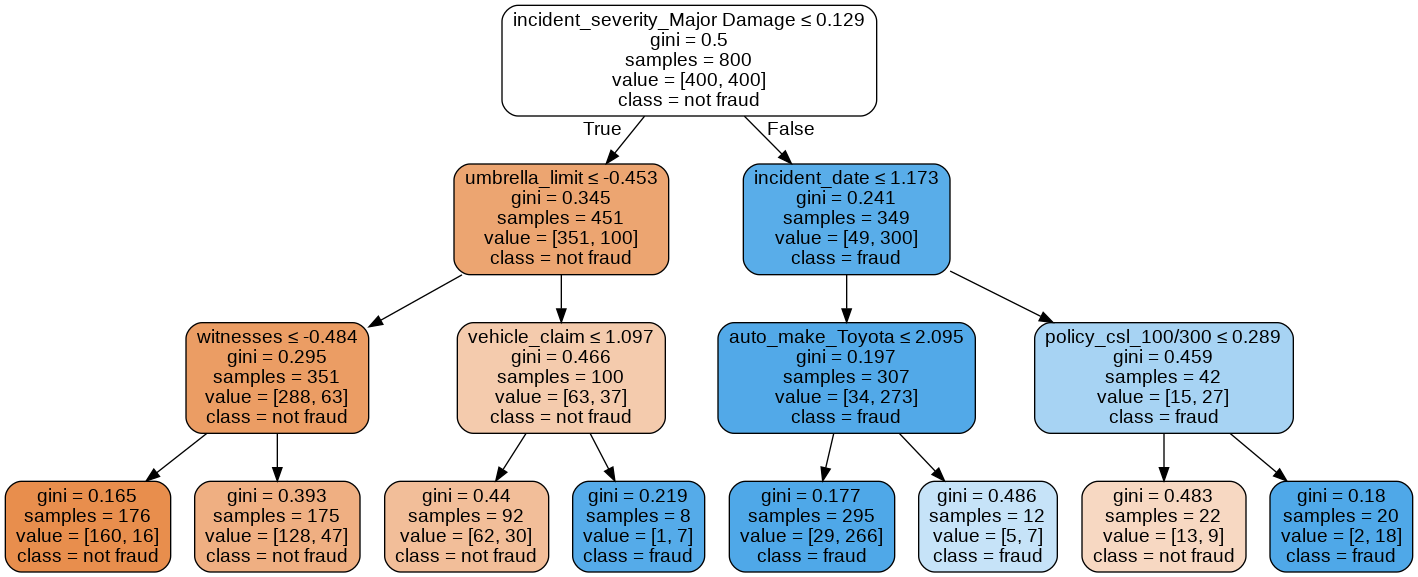

In [ ]:
#Visualizing the tree
#The CV optimized Decision Tree Classifier
best_clf = gs1_results.best_estimator_
#Plot
dot_data = StringIO()
export_graphviz(best_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(X_train.columns),class_names=['not fraud','fraud'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('fraud.png')
Image(graph.create_png())

We see that the decision tree classifer picks up on some similar signals as the penalized logistic regression, namely `incident_severity_Major Damage`, `umbrella_limit` and `auto_make_Toyota`. However, there are also some additional predictors that the tree picks up on that are in the second and third layers of the tree – `incident_date`, `witnesses`, `vehicle_claim` and `policy_csl_100/300`. This hints at the presence of interaction effects (or possibly nonlinearity) that may not have been picked up on by the linear logisitc models.

## Random Forest Classifier

We expect the random forests classifier to outperform the decision tree classifer because it reduces overfitting as well as performing feature selection. As we saw from the penalized logistic regression which eliminated 12 predictors for a moderate improvement in performance over the baseline, feature selection may be a useful tool for this dataset.

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, max_features='sqrt',criterion='gini', random_state=12345, n_jobs=-1)
#since increasing the number of trees in forest cannot lead to overfitting, we just use some large number (e.g. 100)
#as per ISLR, we choose predictor subsample = sqrt(number of predictors)
#seed for replicability, very large tree max_depth to grow large tree before pruning

#We do a GridSearch cross-validation to determine the best parameters for the Random Forest Classifier
#The ccp_alphas grid from the decision tree classifers contains too many redundant variables, 
#which proves costly when running these more complicated models. We reduce the grid to something more manageable
ccp_alphas = [0, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.004, 0.005, 0.006, 0.01, 0.2]
rfc_params = {'max_depth':[2,3,5,7,12,15,20,30,50], 'ccp_alpha': ccp_alphas} 

gs2 = GridSearchCV(estimator=rfc, param_grid=rfc_params, scoring='roc_auc', cv=10) #use default 10-fold
gs2_results = gs2.fit(X_train, y_train)
print(gs2_results.best_params_)

gs2_predictions = gs2.predict(X_test)
print(roc_auc_score(y_test, gs2_predictions))

{'ccp_alpha': 0.001, 'max_depth': 20}
0.7930746766791823


A `ccp_alpha` of 0.001 and a `max_depth` of 20 are the best parameters for our random forests classifier, coming in with an AUC of 0.793. This is a slight improvement over the baseline decision tree classifer, which had an AUC of 0.782. It is surprising that the improvement is not as substantial.

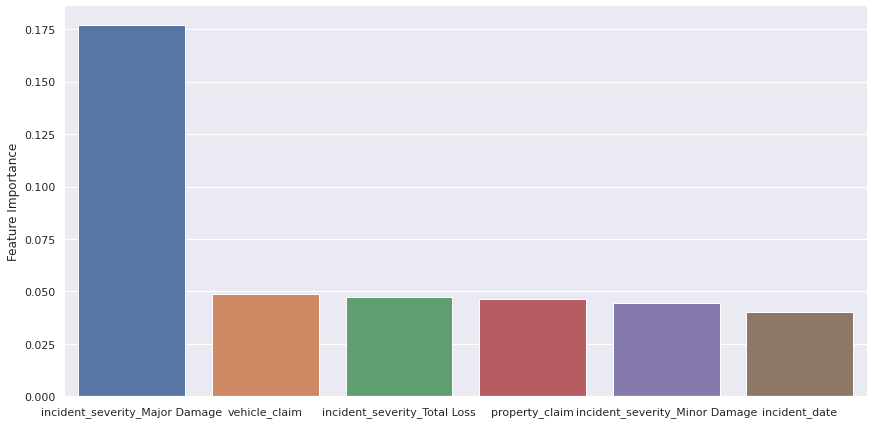

In [ ]:
#We can also see which features the random forest thinks is important
#Create dataframe of feature importances
best_rfc = gs2_results.best_estimator_
feature_importances = pd.DataFrame(data=best_rfc.feature_importances_)
labels = pd.DataFrame(X_train.columns)
feature_importances = pd.concat([labels, feature_importances], axis =1)
#Clean and sort dataframe
feature_importances.columns = ['Features', 'Importance']
feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
#Graph top 6 most significant features
g = sns.catplot(data=feature_importances.head(6), x='Features', y='Importance', kind="bar", height=6, aspect=2)
g.despine(left=True)
g.set_axis_labels("", "Feature Importance")

A familiar face in `incident_severity_Major Damage`, `vehicle_claim` and `incident_date`, but the rest are different. Other notable predictors like `umbrella_limit` is not used here.

## Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, max_features='sqrt', random_state=12345)
gbc_params = {'learning_rate': [0.005 ,0.01, 0.1, 0.2, 0.5, 0.7], 
              'max_depth':[2,3,5,7,12,15,20,30,50], 
              'ccp_alpha': ccp_alphas} 

gs3 = GridSearchCV(estimator=gbc, param_grid=gbc_params, scoring='roc_auc', cv=10)
gs3_results = gs3.fit(X_train, y_train)
print(gs3_results.best_params_)

gs3_predictions = gs3.predict(X_test)
print(roc_auc_score(y_test, gs3_predictions))

{'ccp_alpha': 0, 'learning_rate': 0.01, 'max_depth': 12}
0.8004450006953137


A `ccp_alpha` of 0, a `max_depth` of 1, and a learning rate of 0.01 are the best parameters for our gradient boosting classifier, giving an AUC of 0.800. This is minor improvement over the random forest classifer, which had an AUC of 0.793, but it is small enough to be considered insignificant.

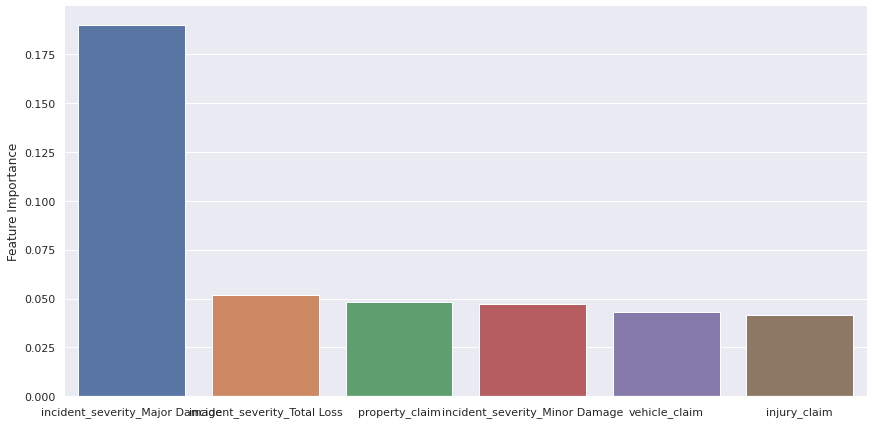

In [ ]:
#We can also see which features the random forest thinks is important
#Create dataframe of feature importances
best_gbc = gs3_results.best_estimator_
feature_importances1 = pd.DataFrame(data=best_gbc.feature_importances_)
labels = pd.DataFrame(X_train.columns)
feature_importances1 = pd.concat([labels, feature_importances1], axis =1)
#Clean and sort dataframe
feature_importances1.columns = ['Features', 'Importance']
feature_importances1.sort_values(by='Importance', ascending=False, inplace=True)
#Graph top 6 most significant features
g = sns.catplot(data=feature_importances1.head(6), x='Features', y='Importance', kind="bar", height=6, aspect=2)
g.despine(left=True)
g.set_axis_labels("", "Feature Importance")

Again, we the `incident_severity`, `property_claim` and `vehicle_claim` as in random forests.

## XGBoost Classifier

In [ ]:
#Note there is no visibility into feature importance with this model implementation
xgb = XGBClassifier(n_estimators=100, random_state=12345, n_jobs=-1)
xgb_params = {'learning_rate': [0.01, 0.1, 0.2, 0.35, 0.5, 0.7, 1], 
              'max_depth':[2,3,5,7,12,15,20,30,50]} 

gs4 = GridSearchCV(estimator=xgb, param_grid=xgb_params, scoring='roc_auc', cv=10)
gs4_results = gs4.fit(X_train, y_train)
print(gs4_results.best_params_)

gs4_predictions = gs4.predict(X_test)
print(roc_auc_score(y_test, gs4_predictions))

{'learning_rate': 0.5, 'max_depth': 5}
0.7276456681963566


A `ccp_alpha` of 0.5 and a `max_depth` of 5 are the best parameters for our XGBoost classifier, giving an AUC of 0.728. This is significantly worse than all the other models we have used. This is likely because of XGBoost's well-known tendency to be prone to overfitting. It is possible that further tuning of the hyperparameters would produce moderate improvements, but it is unlikely to outperform gradient boosting or random forests.

#Conclusion

We begun this analysis with the goals of understanding and predicting fraud incidence in the US. With regards to understanding, we have observed that most predictors do not contain any meaningful signal. However, a few predictors such as `incident_severity`, `property_claim` and `vehicle_claim` were consider highly important features in the majority of the models which we ran. The difference between the AUC score of the best linear model (0.778) and the best tree-based model (0.8) is relatively small. This may suggest that while there exists some nonlinearity or interaction effects in the data, it is not extremely significant.<br><br>
We had moderate success with our prediction of fraud incidence. Our best performing models were the random forests and gradient boosting classifiers with AUC scores of 0.793 and 0.8. We believe is a relatively good score for this dataset, as this data seems to contain relatively low signal and high noise, as postulated when analysing the output of our logistic regression. 

# References

[1]https://www.kaggle.com/buntyshah/auto-insurance-claims-data </br>
[2]https://www.iii.org/article/background-on-insurance-fraud </br>
[3]https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/494105/PU1817_Insurance_Fraud_Taskforce.pdf </br>
[4]https://www.investopedia.com/terms/c/combined-single-limits.asp</br>
[5]https://stats.stackexchange.com/questions/230750/when-should-we-discretize-bin-continuous-independent-variables-features-and-when?rq=1 </br>
[6]https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-017-0442-1<br>
[7]https://scikit-learn.org/stable/modules/impute.html#impute <br>
[8]https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35<br>
[9]https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn<br>
[10]https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/<br>
[11]https://arxiv.org/abs/1106.1813<br>
[12]https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py<br>
[13]https://stats.stackexchange.com/questions/250937/which-loss-function-is-correct-for-logistic-regression<br>
[14]https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x<br>
[15]https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html<br>

